#### Last Modified: July 26th, 2022 (Opal). 

# sOpInf applied to the Inviscid Burgers' Equation (Example #1)

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/oissan/PycharmProjects/Space-Weather-ROM-Revised'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import rom_operator_inference as roi
import scipy 
from scipy import stats
import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
# -size for paper figures
# import matplotlib.pyplot as plt
# import matplotlib
# font = {'family' : 'serif',
#         'size'   : 18}

# matplotlib.rc('font', **font)
# matplotlib.rc('xtick', labelsize=16) 
# matplotlib.rc('ytick', labelsize=16) 

### Shifted Operator Inference (sOpInf) Applied to the Invisicid Burgers Equation
The one-dimensional invisicid Burgers' equation is of the form:

\begin{equation} \label{inviscid-burgers-equation}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0
\end{equation}

subject to the initial condition $u(x, t=0)=u_{0}(x)$ with boundary conditions at $x=a$ and $x=b$. In the moving coordinate frame, $u(x, t) = \tilde{u} (x + c(t), t)$, Eq. above becomes 

\begin{equation}\label{shifted-inviscid-burgers-equation}
\frac{\partial \tilde{u}}{\partial t} + \left(\tilde{u} + \frac{dc}{dt}\right) \frac{\partial \tilde{u}}{\partial \tilde{x}} = 0
\end{equation}

which can be written in conservative form as

\begin{equation}\label{shifted-burgers-conservative}
\frac{\partial \tilde{u}}{\partial t} +  \frac{\partial}{\partial \tilde{x}}\left[g(\tilde{u})\right] = 0
\end{equation}

with $g(\tilde{u}) = \frac{1}{2}\tilde{u}^2 + \frac{dc}{dt} \tilde{u}$. Then, by the conservative first-order upwind scheme, we approximate the derivative of the flux function $g$ with respect to $\tilde{x}$ by

\begin{equation} \label{conservative-upwind-scheme-burgers}
    \frac{\partial}{\partial \tilde{x}} [g(\tilde{u})] \approx \frac{1}{\Delta \tilde{x}}  \{g[\tilde{u}(\tilde{x}_{j+1}, t)] - g[\tilde{u}(\tilde{x}_{j}, t)]\}
\end{equation}

where $j$ denotes the grid index in $\tilde{x}$. In vector form, we can write the dynamics in quadratic form:

\begin{equation} \label{shifted-burgers-vector-form-quad}
\frac{d\mathbf{\tilde{u}}}{d t} = \mathbf{H} (\mathbf{\tilde{u}} \otimes \mathbf{\tilde{u}}) + \mathbf{A}(t) \mathbf{\tilde{u}}
\end{equation}

where $\otimes$ denotes the Kronecker product and  $\mathbf{\tilde{u}} = [\mathbf{\tilde{u}}(\tilde{x}_{1}, t), \mathbf{\tilde{u}}(\tilde{x}_{2}, t), ..., \mathbf{\tilde{u}}(\tilde{x}_{n}, t)]^{\top} \in \mathbb{R}^{n}$ is the state vector discretized over $n$ spatial points at time $t$. The operator $\mathbf{A}(t) \in \mathbb{R}^{n \times n}$ is the linear operator and $\mathbf{H} \in \mathbb{R}^{n \times n^2}$ is the quadratic operator. If $c(t)$ is linear, meaning the wave is traveling in constant speed, then the linear operator $\mathbf{A}(t) = \mathbf{A}$ does not depend on time. Given the FOM is in polynomial form, Operator Inference can maintain the same polynomial structure in the  low-dimensional basis with high accuracy.


### Set Rectangular Computational Grid Size

In [4]:
# number of mesh points in the T (time) axis. 
m = 1000
# number of mesh points in X (spatial) axis. 
n = 500
# final time. 
T = 2
# boundary of x [a, b].
a = 0
b = 3

In [5]:
# time and spatial grid (uniform spacing).
t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)[:-1]

### Set Initial Condition

In [6]:
# gaussian initial condition
initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

### Numerical Solution via Finite Differencing

We solve the inviscid Burgers' equation via the first-order finite difference upwind scheme with forward Euler 
$$
u_{j}^{n+1} = u_{j}^{n} - \frac{\Delta t}{2\Delta x} \left( (u^{n}_{j})^{2} - (u^{n}_{j-1})^{2} \right)
$$


In [7]:
# flux function
def flux(u): 
    return 0.5*(u**2)

def solve_upwind_scheme(initial_condition, t_vec, x_vec):
    """ solve a 1-d advection diffusion equation using the first order conservative upwind scheme"""
    U = np.zeros((len(x_vec), len(t_vec)))
    
    U[:, 0] = initial_condition
    
    dt = np.mean(t_vec[1:] - t_vec[:-1])
    dx = np.mean(x_vec[1:] - x_vec[:-1])
    
    for ii in range(len(t_vec)-1):
        for jj in range(len(x_vec)):
            if (U[jj, ii] * dt/dx) > 1:
                print("Warning: CFL condition violated. ")
                
            # update the next cell.
            U[jj, ii+1] = U[jj, ii] + (dt/dx)*(flux(U[jj-1, ii])  - flux(U[jj, ii]))
    return U

In [8]:
U_sol = solve_upwind_scheme(initial_condition, t_vec, x_vec)

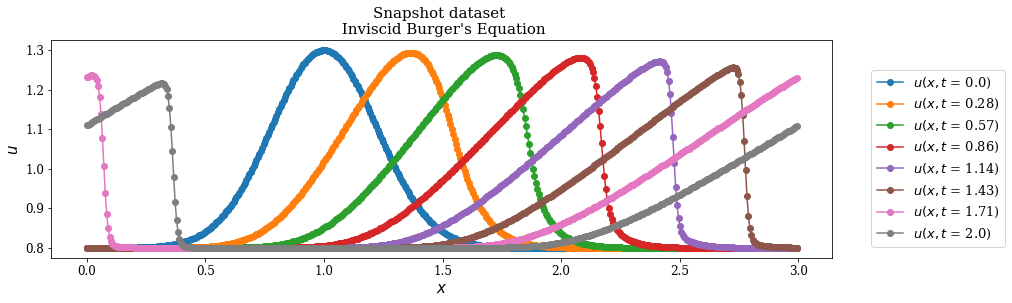

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 8):
    ax.plot(x_vec, U_sol[:, int(ii)], "-o", label="$u(x, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Snapshot dataset \n Inviscid Burger's Equation", fontsize=15)
_ = ax.legend()
_ = ax.legend(loc=(1.05, .05))

## Compute the spatial shift function $c(t)$
### Method #1:  The Method of Characteristics (with shock capturing)

In [10]:
moc = np.loadtxt('Burgers/shock_curve.csv', delimiter=',')

### Method #2: Cross-Correlation Extrapolation Method

In [11]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

In [12]:
# initialize shift function 
shift_vec = np.zeros(len(t_vec))

for ii in range(1, len(t_vec)):
    corr = periodic_corr_np(U_sol[:, ii], U_sol[:, 0])
    shift_vec[ii] = (x_vec[np.argmax(corr)])

In [13]:
# training ends
n = int(len(t_vec)*0.8)

def func_linear(xi, t):
    return xi*t

m_mean = scipy.optimize.curve_fit(func_linear, t_vec[:n], shift_vec[:n])[0][0]
m_mean

1.0504159873634116

In [14]:
def c_t(t_idx, t_vec, method="moc", xi=m_mean):
    if method=="moc":
        return np.loadtxt('Burgers/shock_curve.csv', delimiter=',')[t_idx]
    if method=="cce":
        return t_vec[t_idx]*xi

In [15]:
# shift all snapshots by c(t) 
U_new = np.zeros(U_sol.shape)
U_new[:, 0] = U_sol[:, 0]

for ii in range(1, len(t_vec)):
    shift= c_t(t_idx=ii, t_vec=t_vec, method="moc") 
    U_new[:, ii] = np.interp(x_vec + shift, x_vec, U_sol[:, ii], period=b) 

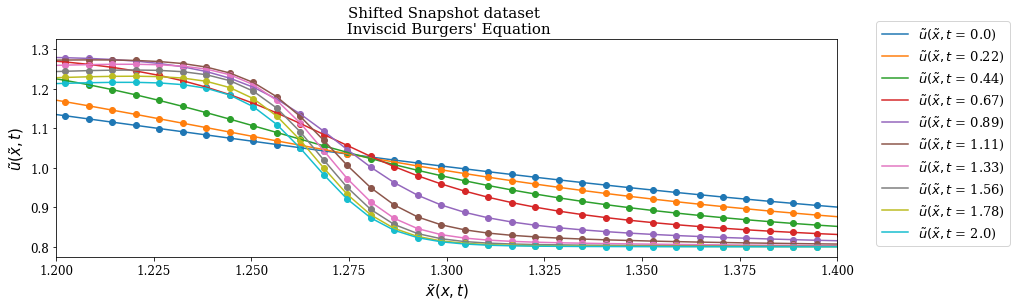

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 10):
    ax.plot(x_vec, U_new[:, int(ii)], "-", label=r"$\tilde{u}(\tilde{x}, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
    ax.scatter(x_vec, U_new[:, int(ii)])
_ = ax.legend(loc=(1.05, .05))
_ = ax.set_xlim(1.2, 1.4)
_ = ax.set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
_ = ax.set_ylabel(r"$\tilde{u}(\tilde{x}, t)$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted Snapshot dataset \n Inviscid Burgers' Equation", fontsize=15)

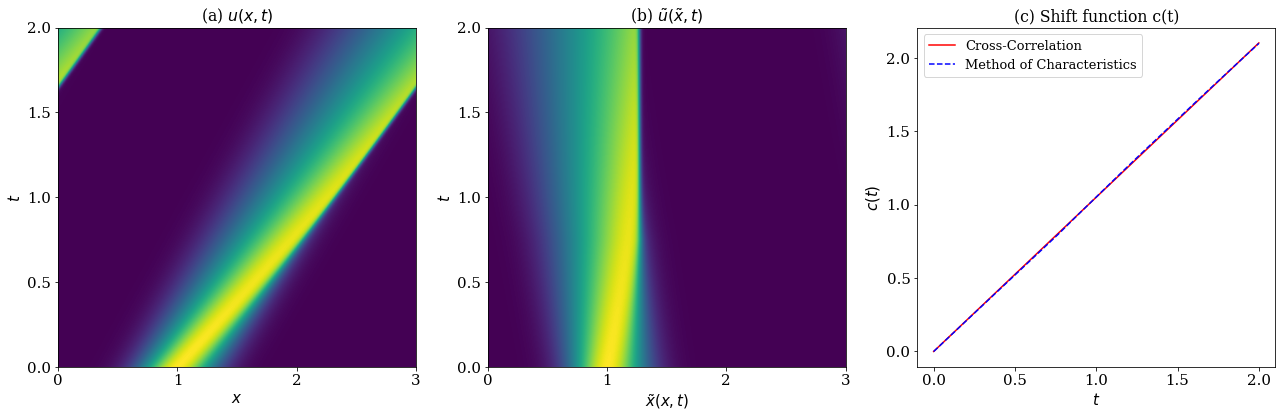

In [17]:
fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(18, 6))
ax[0].imshow(U_sol.T, extent=[a,b, 0, T], aspect="auto", origin="lower")
ax[1].imshow(U_new.T, extent=[a,b, 0, T],  aspect="auto", origin="lower")

ax[0].set_xlabel(r"$x$", fontsize=15)
ax[1].set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
ax[0].set_ylabel(r"$t$", fontsize=15)
ax[1].set_ylabel(r"$t$", fontsize=15)
ax[0].set_title(r"(a) $u(x, t)$")
ax[1].set_title(r"(b) $\tilde{u}(\tilde{x}, t)$")

ax[2].set_title("(c) Shift function c(t)")
_ = ax[2].plot(t_vec, m_mean*t_vec , c="r", label="Cross-Correlation")
_ = ax[2].plot(t_vec, moc, "--",  c="b",label="Method of Characteristics")
#_ = ax[2].axvline(t_vec[n], color="k", label="Training Ends")

_ = ax[2].set_xlabel("$t$", fontsize=15)
_ = ax[2].set_ylabel("$c(t)$", fontsize=15)
ax[2].legend()

ax[0].set_xticks([0, 1, 2, 3])
ax[0].set_yticks([0, 0.5, 1, 1.5, 2])
ax[1].set_xticks([0, 1, 2, 3])
ax[1].set_yticks([0, 0.5, 1, 1.5, 2])

plt.tight_layout()

plt.savefig("Burgers/figs/burgers_eqn_comparison_of_methods_to_compute_shift.png", dpi=500)

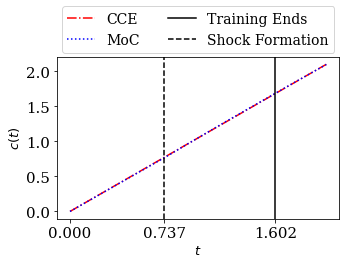

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))
_ = ax.plot(t_vec, m_mean*t_vec ,ls="-.", c="r", label="CCE")
_ = ax.plot(t_vec, moc, ":",  c="b",label="MoC")
_ = ax.axvline(t_vec[n], color="k", label="Training Ends")
ax.axvline(0.7373, c="k", ls="--", label="Shock Formation")
_ = ax.set_xticks([0, 0.737, t_vec[n]])
_ = ax.set_xlabel("$t$")
_ = ax.set_ylabel("$c(t)$")
_ = ax.legend(bbox_to_anchor=[0.5, 1.17],loc='center', ncol=2, fontsize=14)
plt.tight_layout()
plt.savefig("Burgers/figs/shift_function.png", dpi=500)

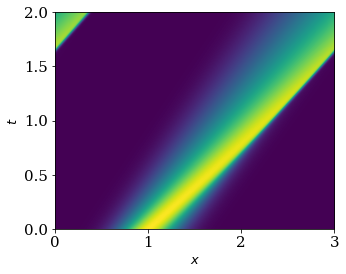

In [19]:
fig, ax = plt.subplots(nrows=1,figsize=(5, 4))
ax.imshow(U_sol.T, extent=[a,b, 0, T], aspect="auto", origin="lower")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 0.5, 1, 1.5, 2])
plt.tight_layout()     
plt.savefig("Burgers/figs/burgers_original.png", dpi=500)

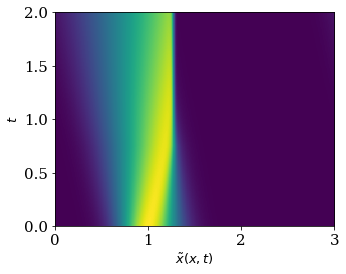

In [20]:
fig, ax = plt.subplots(nrows=1,figsize=(5, 4))
ax.imshow(U_new.T, extent=[a,b, 0, T], aspect="auto", origin="lower", interpolation="nearest")
ax.set_xlabel(r"$\tilde{x}(x, t)$")
ax.set_ylabel("$t$")
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 0.5, 1, 1.5, 2])
plt.tight_layout()     
plt.savefig("Burgers/figs/burgers_shifted.png", dpi=500)

### Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [21]:
# set up the first l indexes used for training. 
l = int(0.8*(len(t_vec)))

In [22]:
X= U_new

In [23]:
X_train = X[:, :l]
X_test = X[:, l:-1]

In [24]:
t_train = t_vec[:l]
t_test = t_vec[l:-1]

In [25]:
print("U train shape", np.shape(X_train))
print("Time Interval train: " + str(t_vec[0]) + " to " + str(t_vec[l]))
print("\nU test shape", np.shape(X_test))
print("Time Interval test: " + str(t_vec[l]) + " to " + str(t_vec[-1]))

U train shape (499, 800)
Time Interval train: 0.0 to 1.6016016016016015

U test shape (499, 199)
Time Interval test: 1.6016016016016015 to 2.0


## Using the ROM Operator Inference Package


### Choosing the reduced-model dimension
A simple choice for the reduced basis is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and evaluated their cumulative energy. 
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [26]:
# compute the singular value decomposition
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(U_sol[:, :l])

In [27]:
# Calculate the cumulative energy.
thresh = .99994 # cumulative energy threshold
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 9
r (Eularian coordinates)= 89


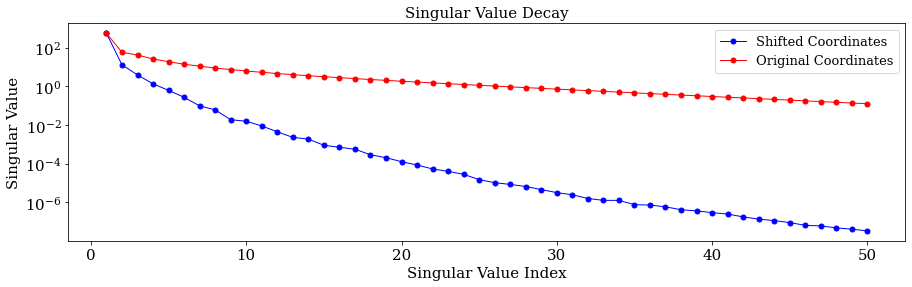

In [28]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
n_sig = 50
ax.plot(np.arange(1, n_sig+1), svdvals[:n_sig], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, n_sig+1), svdvals_prev[:n_sig], '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
ax.set_yscale("log")
plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Singular Value", fontsize=15)
_ = ax.set_title("Singular Value Decay", fontsize=15)

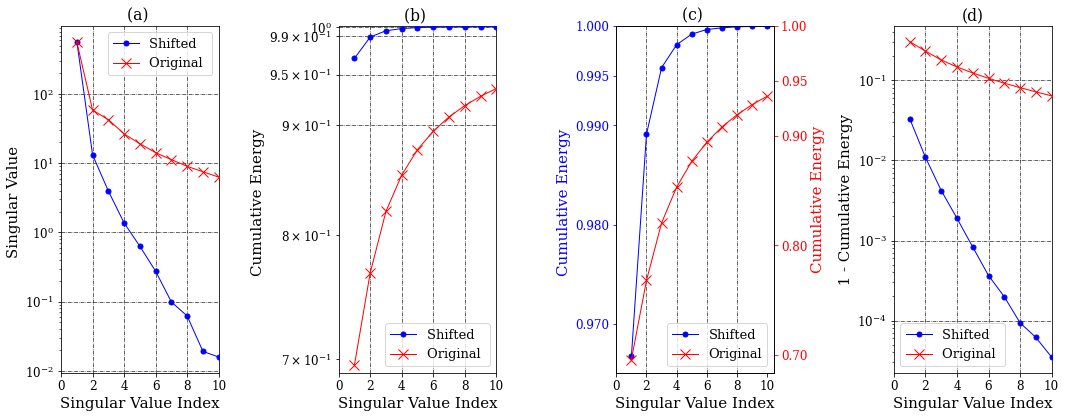

In [29]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(ncols=4, figsize=(15, 6), facecolor=(1, 1, 1))

xlim= 10
ax[0].plot(np.arange(1, xlim + 1), svdvals[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted ")
ax[0].plot(np.arange(1, xlim + 1), svdvals_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r", label="Original ")

_ = ax[0].legend()
_ = ax[0].set_xlim(0, xlim)
_ = ax[0].set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax[0].set_ylabel(r"Singular Value ", fontsize=15)
_ = ax[0].set_yscale("log")
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)
_ = ax[0].set_title("(a) ")
ax[0].set_xticks([0, 2, 4, 6, 8,10])
ax[0].axvline(2, color="black", linewidth=.6, linestyle="-.")
ax[0].axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax[0].axvline(6, color="black", linewidth=.6, linestyle="-.")
ax[0].axvline(8, color="black", linewidth=.6, linestyle="-.")
ax[0].axhline(1e2, color="black", linewidth=.6, linestyle="-.")
ax[0].axhline(1e1, color="black", linewidth=.6, linestyle="-.")
ax[0].axhline(1e-1,  color="black", linewidth=.6, linestyle="-.")
ax[0].axhline(1e-2, color="black", linewidth=.6, linestyle="-.")
ax[0].axhline(1e0, color="black", linewidth=.6, linestyle="-.")

ax[1].plot(np.arange(1, xlim + 1), cum_energy[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted ")
ax[1].plot(np.arange(1, xlim + 1), cum_energy_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r", label="Original ")
ax[1].set_xticks([0, 2, 4, 6, 8,10])
_ = ax[1].legend()
_ = ax[1].set_xlim(0, xlim)
_ = ax[1].set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax[1].set_ylabel(r"Cumulative Energy ", fontsize=15)
_ = ax[1].set_yscale("log")
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
_ = ax[1].set_title("(b) ")
ax[1].axvline(2, color="black", linewidth=.6, linestyle="-.")
ax[1].axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax[1].axvline(6, color="black", linewidth=.6, linestyle="-.")
ax[1].axvline(8, color="black", linewidth=.6, linestyle="-.")
ax[1].axhline(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[1].axhline(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[1].axhline(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[1].axhline(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[1].set_yticks(ticks=[ 0.7, 0.8, 0.9, 0.95, 0.99,  1])
ax[1].set_ylim(0.69, 1.001)
ax[1].legend()

ax[2].plot(np.arange(1, xlim + 1), cum_energy[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted")
ax[2].plot(np.arange(1, xlim + 1)*np.nan, cum_energy_prev[:xlim]*np.nan, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original")
ax2=ax[2].twinx()
ax2.plot(np.arange(1, xlim + 1), cum_energy_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r")
_ = ax2.set_ylabel("Cumulative Energy", c="r", fontsize=15)
_ = ax[2].legend()
_ = ax2.set_yticks(ticks=[0.7, 0.8, 0.9, 0.95,  1])
_ = ax[2].set_yticks(ticks=[ 0.97, 0.98, 0.99, 0.995, 1])
_ = ax[2].set_ylim(top= 1)
_ = ax2.set_ylim(top=1)
_ = ax[2].tick_params(axis='y', colors='blue')
_ = ax2.tick_params(axis='y', colors='red')
_ = ax[2].set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax[2].set_ylabel(r"Cumulative Energy ", c="b", fontsize=15)
_ = ax[2].tick_params(axis='both', which='major', labelsize=12)
_ = ax2.tick_params(axis='both', which='major', labelsize=12)
_ = ax[2].set_title("(c) ")
ax[2].set_xticks([0, 2, 4, 6, 8,10])
ax[2].axvline(2, color="black", linewidth=.6, linestyle="-.")
ax[2].axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax[2].axvline(6, color="black", linewidth=.6, linestyle="-.")
ax[2].axvline(8, color="black", linewidth=.6, linestyle="-.")


ax[3].plot(np.arange(1, xlim + 1), 1- cum_energy[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted ")
ax[3].plot(np.arange(1, xlim + 1), 1 - cum_energy_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r", label="Original ")
ax[3].set_xticks([0, 2, 4, 6, 8,10])
_ = ax[3].legend()
_ = ax[3].set_xlim(0, xlim)
_ = ax[3].set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax[3].set_ylabel(r" 1 - Cumulative Energy ", fontsize=15)
_ = ax[3].set_yscale("log")
_ = ax[3].tick_params(axis='both', which='major', labelsize=12)
_ = ax[3].set_title("(d)")
ax[3].axvline(2, color="black", linewidth=.6, linestyle="-.")
ax[3].axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax[3].axvline(6, color="black", linewidth=.6, linestyle="-.")
ax[3].axvline(8, color="black", linewidth=.6, linestyle="-.")
ax[3].axhline(1e-1, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].axhline(1e-2, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].axhline(1e-3, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].axhline(1e-4, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].legend()
plt.tight_layout()     

plt.savefig("Burgers/figs/singular_value_decay_burgers_comparison.png", pad_inches=1)

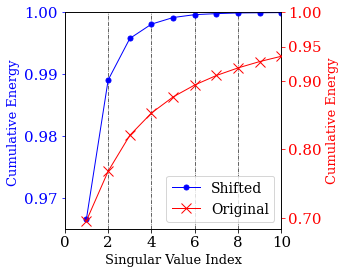

In [30]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(5, 4))
xlim= 10
ax.plot(np.arange(1, xlim + 1), cum_energy[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted")
ax.plot(np.arange(1, xlim + 1)*np.nan, cum_energy_prev[:xlim]*np.nan, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original")
ax2=ax.twinx()
ax2.plot(np.arange(1, xlim + 1), cum_energy_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r")
_ = ax2.set_ylabel("Cumulative Energy", c="r")
_ = ax.legend(loc="lower right", fontsize=14)
#_ = ax.set_yscale("log")
_ = ax2.set_yticks(ticks=[0.7, 0.8, 0.9, 0.95,  1])
_ = ax.set_yticks(ticks=[ 0.97, 0.98, 0.99, 1])
_ = ax.set_ylim(top= 1)
_ = ax2.set_ylim(top=1)
_ = ax.tick_params(axis='y', colors='blue')
_ = ax2.tick_params(axis='y', colors='red')
_ = ax.set_xlabel(r"Singular Value Index")
_ = ax.set_ylabel(r"Cumulative Energy ", c="b")
_ = ax.tick_params(axis='both', which='major')
_ = ax2.tick_params(axis='both', which='major')
ax.set_xticks([0, 2, 4, 6, 8,10])
ax.axvline(2, color="black", linewidth=.6, linestyle="-.")
ax.axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax.axvline(6, color="black", linewidth=.6, linestyle="-.")
ax.axvline(8, color="black", linewidth=.6, linestyle="-.")
ax.axvline(10, color="black", linewidth=.6, linestyle="-.")
ax.set_xlim(0, 10)
plt.tight_layout()
plt.savefig("Burgers/figs/singular_value_decay_burgers.png",  dpi=700)

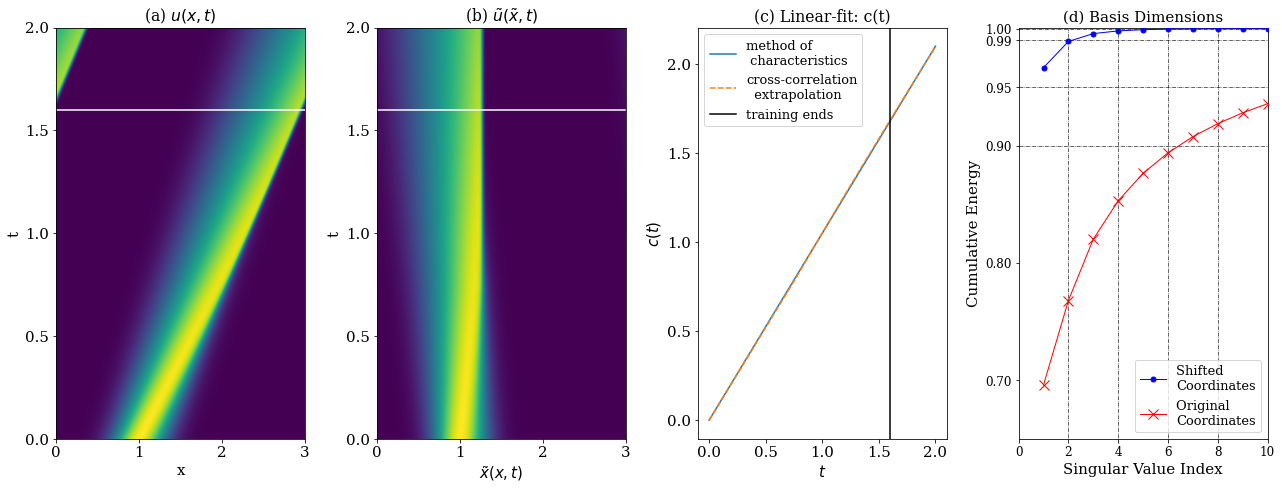

In [31]:
fig, ax = plt.subplots(ncols=4, nrows=1,figsize=(18, 7))
ax[0].imshow(U_sol.T, extent=[a,b, 0, T], aspect="auto", origin="lower")
ax[1].imshow(U_new.T, extent=[a,b, 0, T],  aspect="auto", origin="lower")

ax[0].set_xlabel("x", fontsize=15)
ax[1].set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
ax[0].set_ylabel("t", fontsize=15)
ax[1].set_ylabel("t", fontsize=15)
ax[0].set_title(r"(a) $u(x, t)$")
ax[1].set_title(r"(b) $\tilde{u}(\tilde{x}, t)$")

ax[0].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")


ax[2].set_title("(c) Linear-fit: c(t)" )#+ str(round(b_slope, 2)))

ax[2].plot(t_vec, m_mean*t_vec, "-", label="method of \n characteristics")
ax[2].plot(t_vec, moc, "--", label="cross-correlation\n  extrapolation")
_ = ax[2].set_xlabel("$t$", fontsize=15)
_ = ax[2].set_ylabel("$c(t)$", fontsize=15)
ax[2].axvline(t_train[-1], color="black", label="training ends")
ax[2].legend()


# plot singluar values cumulative energy
ax[3].plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted \nCoordinates")
ax[3].plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original \nCoordinates")
# get current y-limits 
ylim = ax[3].get_ylim()

# set up axis. 
ax[3].hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax[3].hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

ax[3].vlines(2, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax[3].vlines(4, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax[3].vlines(6, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax[3].vlines(8, 0, 1, color="black", linewidth=.6, linestyle="-.")


plt.legend()

_ = ax[3].set_xlim(0, xlim)
_ = ax[3].set_ylim(bottom=0.65, top=1.001)
_ = ax[3].set_yticks(ticks=[0.7, 0.8, 0.9, 0.95, 0.99, 1])
_ = ax[0].set_yticks(ticks=[0, 0.5, 1, 1.5, 2])
_ = ax[1].set_yticks(ticks=[0, 0.5, 1, 1.5, 2])
_ = ax[3].set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax[3].set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax[3].set_title("(d) Basis Dimensions", fontsize=15)
_ = ax[3].tick_params(axis='both', which='major', labelsize=12)


plt.tight_layout()

plt.savefig("Burgers/figs/burgers_eqn_comparison_of_methods_to_compute_shift.png", dpi=500)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined. If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [32]:
rank=9
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (499, 9)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

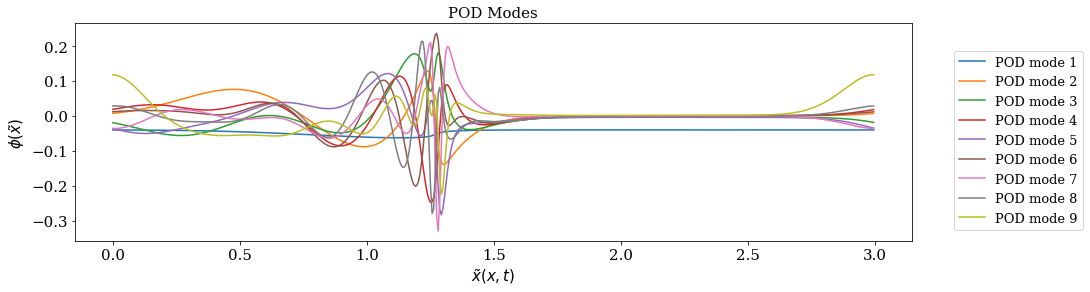

In [33]:
fig, ax = plt.subplots(figsize=(15, 4))
for ii in range(9):
    ax.plot(x_vec, Vr[:,ii],  label=f"POD mode {ii+1}")
ax.legend(loc=(1.05, .05))
ax.set_xlabel(r"$\tilde{x}(x, t)$", fontsize=15)
ax.set_ylabel(r"$\phi(\tilde{x})$", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
plt.show()

In [34]:
roi.pre.projection_error(X_train, Vr)

3.322001202313698e-05

In [35]:
def convert_from_x_to_v(X_ROM, b=3):
    """ convert the ROM results back to the original coordinates. (extrapolating c(t))"""
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    for jj in range(1, len(t_vec)):
        shift = c_t(jj, t_vec, method="moc")
        V_ROM[:, jj] = np.interp(x_vec - shift, x_vec, X_ROM[:, jj], period=b) 
    return V_ROM

In [36]:
def regularizer(r, λ1, λ2):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.

    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    diag𝚪 = np.full(r2, λ1)
    diag𝚪[r1:-1] = λ2
    return diag𝚪

# Quadratic-Linear ROM $\dot{\hat u} = \hat{A} \hat{u} + \hat{H} (\hat{u} \otimes \hat{u})$

In [37]:
rank=9
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
Xdot = roi.pre.xdot(X_train, t_vec[1]-t_vec[0], order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH") # Define the model structure.
model.fit(Vr, X_train, Xdot, P=regularizer(rank, 1e0, 1e0)) # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.

In [38]:
V_ROM = convert_from_x_to_v(X_ROM)

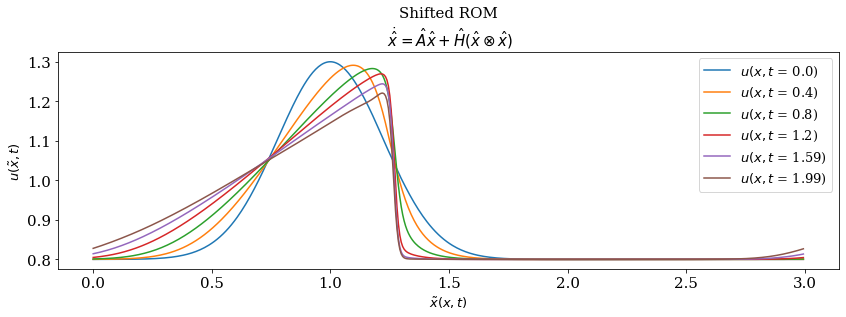

In [39]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, X_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel(r"$\tilde{x}(x, t)$")
_ = ax.set_ylabel(r"$u(\tilde{x}, t)$")
_ = ax.tick_params(axis='both', which='major')
_ = ax.set_title("Shifted ROM\n $\dot{\hat x} = \hat{A} \hat{x} + \hat{H} (\hat{x} \otimes \hat{x})$", fontsize=15)
_ = ax.legend()

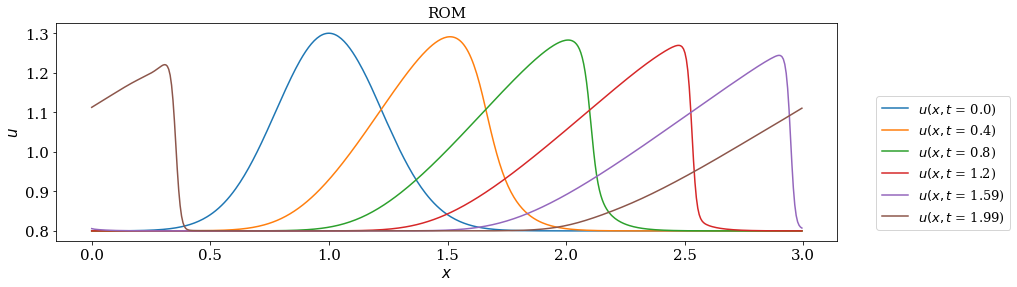

In [40]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, V_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major')
_ = ax.set_title("ROM", fontsize=15)
_ = ax.legend(loc=(1.05, .05))

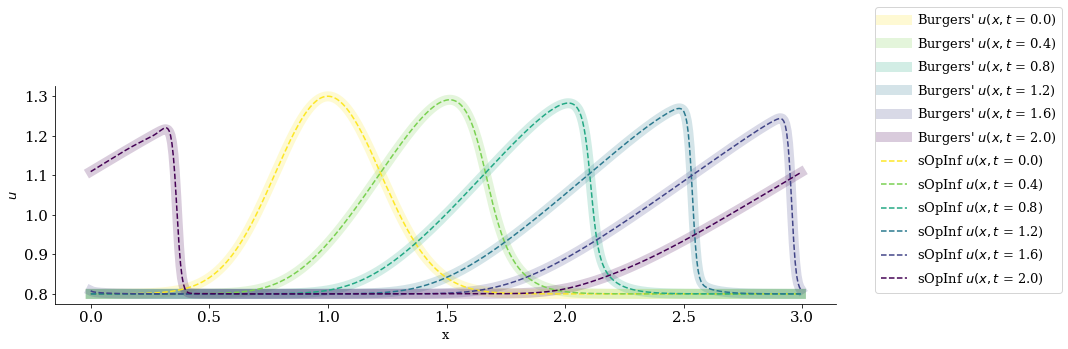

In [41]:
sample_columns = np.arange(0, len(t_vec), int(len(t_vec)//5))
sample_columns = np.append(sample_columns, len(t_vec) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(x_vec, U_sol[:, j], color=curr_color, linewidth=10.0, alpha=0.2,  label="Burgers' $u(x, t$ = "+ str(round(t_vec[j], 2)) + ")")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(x_vec, V_ROM[:, j],color=curr_color, ls="--", label="sOpInf $u(x, t$ = "+ str(round(t_vec[j], 2)) + ")")

ax.set_xlabel("x")
ax.set_ylabel("$u$")
ax.legend(loc=(1.05, .05), fontsize=13)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
_ = ax.tick_params(axis='both', which='major')

fig.savefig("Burgers/figs/sopinf_vs_burgers_moc.png", dpi=500, bbox_inches='tight')

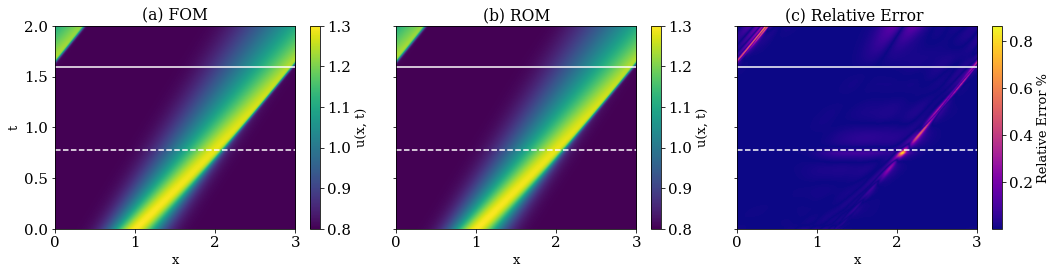

In [42]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(U_sol.T, extent=[a, b,0, T], vmax=0.8, vmin=1.3, aspect="auto", origin="lower")
ax[0].set_xlabel(r"x")
ax[0].set_ylabel(r"t")
ax[0].set_title("(a) FOM")
ax[0].plot(x_vec, t_train[386]* np.ones(len(x_vec)), ls="--", c="white")
ax[0].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('u(x, t)', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[a,b, 0, T], vmax=0.8, vmin=1.3, aspect="auto", origin="lower")
ax[1].set_xlabel(r"x")
ax[1].set_title("(b) ROM")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
ax[1].plot(x_vec, t_train[386]* np.ones(len(x_vec)), ls="--", c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('u(x, t)', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM.T - U_sol.T)/np.abs(U_sol).T, extent=[a,b, 0, T], 
                   cmap="plasma", aspect="auto", origin="lower")
ax[2].set_xlabel(r"x")
ax[2].set_title("(c) Relative Error ")
ax[2].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
ax[2].plot(x_vec, t_train[386]* np.ones(len(x_vec)), ls="--", c="white")
cbar = fig.colorbar(pos, ax=ax[2])

cbar.ax.set_ylabel('Relative Error %', rotation=90)
#plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()
plt.savefig("Burgers/figs/relative_error_burgers.png")

In [43]:
RE = 100*np.abs((U_sol - V_ROM))/np.abs(U_sol)
x_max, t_max = np.unravel_index((RE).argmax(), RE.shape)
RE[x_max, t_max]
x_vec[x_max]
t_vec[t_max]


0.7487487487487487

In [44]:
print("mean relative error = " + "{:.4e}".format(np.mean(np.abs((U_sol - V_ROM))/np.abs(U_sol))))

mean relative error = 1.2045e-04


In [45]:
print("pcc = ", stats.pearsonr(np.ndarray.flatten(U_sol), np.ndarray.flatten(V_ROM))[0])

pcc =  0.9999958146658847


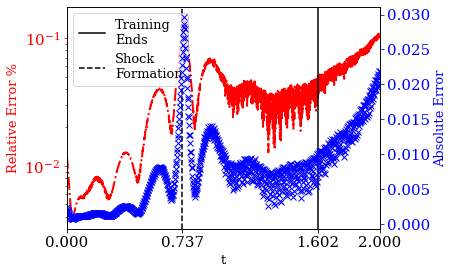

In [46]:
fig, ax = plt.subplots(figsize=(6.5, 4))
abs_l2err, rel_l2err = roi.post.lp_error(U_sol, V_ROM, p=2)
_ = ax.plot(t_vec, 100*rel_l2err,"-.", linewidth=2, c="r")
_ = ax.axvline(t_vec[l], c="k", ls="-",  label="Training\nEnds")
_ = ax.axvline(t_vec[368], c="k", ls="--",  label="Shock\nFormation")
#_ = ax.set_title(r"$\ell^2$ Error")
_ = plt.yscale("log")
_ = ax.set_ylabel("Relative Error %", c="r")
_ = ax.tick_params(axis='y', colors='r')
_ = ax.set_xlim(0, T)
_ = ax.set_xlabel("t")
_ = ax.legend(loc="upper left")
_ = ax.set_xticks([0,  round(t_vec[368], 3),   round(t_vec[l], 3), 2])
ax2=ax.twinx()

_ = ax2.plot(t_vec, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Absolute Error", c="b")
_ = ax2.tick_params(axis='y', colors='b')
#_ = ax2.set_yscale("log")
_ = ax2.set_xlim(0, T)
plt.tight_layout()
plt.savefig("Burgers/figs/ell_2_relative_error.png", dpi=700)

# Optimize free parameters $\lambda_{1}, \lambda_{2}, r$

In [47]:
coeff1_array = 10**np.arange(0, 10)
coeff2_array = 10**np.arange(0, 10)
rank_array = [9]

training_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * np.inf

In [48]:
for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        for ii, rank_r in enumerate(rank_array):
            Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
            Xdot = roi.pre.xdot(X_train, (t_vec[1] - t_vec[0]), order=6)           
            model = roi.InferredContinuousROM(modelform="AH")              
            model.fit(Vr, X_train, Xdot, P=regularizer(rank_r, coeff1, coeff2))  
            X_ROM = model.predict(X[:, 0], t_vec, method="BDF") 

            if np.shape(X_ROM) == np.shape(X):
                V_ROM = convert_from_x_to_v(X_ROM)
                # save training error
                training_error[kk, jj, ii] =np.max(np.abs(U_sol[:, :l] -  V_ROM[:, :l])/U_sol[:, :l])
                # save testing error
                testing_error[kk, jj, ii] = np.max(np.abs(U_sol[:, l:] -  V_ROM[:, l:])/U_sol[:, l:])

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


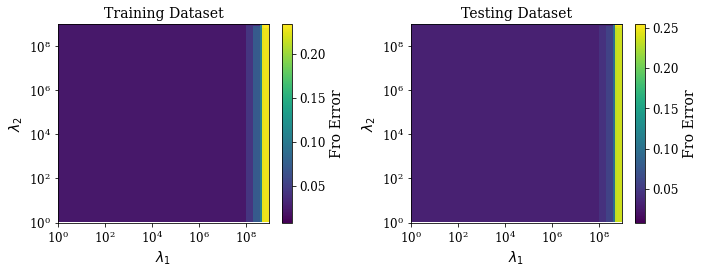

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error[:, :, 0].T, extent=[coeff1_array[0], coeff1_array[-1], 
                                          coeff2_array[0], coeff2_array[-1]],  aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[0].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[0].set_title("Training Dataset", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('Fro Error', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error[:, :, 0].T, extent=[coeff1_array[0], coeff1_array[-1], 
                                          coeff2_array[0], coeff2_array[-1]],  aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[1].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[1].set_title("Testing Dataset", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('Fro Error', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[0].set_yscale("log")

plt.tight_layout()

In [50]:
idx  = np.unravel_index(training_error[:, :, :].argmin(), training_error[:, :, :].shape)
print("Training lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff2_array[idx[1]]))
print("Training rank =",  rank_array[idx[2]])

Training lambda1 = 3.0
Training lambda2 = 0.0
Training rank = 9


In [51]:
idx  = np.unravel_index(testing_error[:, :, :].argmin(), testing_error[:, :, :].shape)
print("Testing lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff2_array[idx[1]]))
print("Testing rank =",  rank_array[idx[2]])

Testing lambda1 = 2.0
Testing lambda2 = 0.0
Testing rank = 9


# Sensitivity to Training Data


In [52]:
# initialize the training length. 
l1, l2, l3, l4 = 500, 600, 700, 800

X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]

X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]

X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

X_train4 = X[:, :l4]
X_test4 = X[:, l4:-1]

In [53]:
r_train1 = t_vec[:l1]
r_test1 = t_vec[l1:-1]

r_train2 = t_vec[:l2]
r_test2 = t_vec[l2:-1]

r_train3 = t_vec[:l3]
r_test3 = t_vec[l3:-1]

r_train4 = t_vec[:l4]
r_test4 = t_vec[l4:-1]

In [54]:
# l1 = compute the results for quadradic.
rank=9
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                    # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, t_vec[1] - t_vec[0], order=6)    # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=regularizer(rank, 1, 1))   # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, t_vec[1] - t_vec[0], order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=regularizer(rank, 1, 1))                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, t_vec[1] - t_vec[0], order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=regularizer(rank, 1, 1))                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

# l4 = compute the results for quadradic.
Vr, _ = roi.pre.pod_basis(X_train4, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train4, t_vec[1] - t_vec[0], order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train4, Xdot, P=regularizer(rank, 1, 1))                          # Construct the ROM with Operator Inference.
X_ROM4 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM4 = convert_from_x_to_v(X_ROM4)

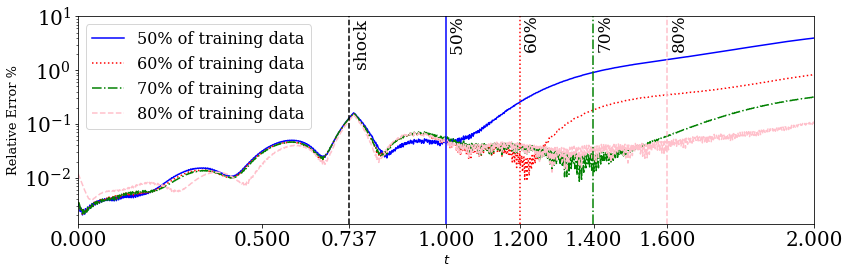

In [55]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


fig, ax = plt.subplots(figsize=(12, 4))

# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(U_sol, V_ROM1, p=2)
_ = ax.plot(t_vec, 100*rel_l2err1, "-", c="b", label=str(round(100*t_vec[l1]/T)) + "% of training data")

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(U_sol, V_ROM2, p=2)
_ = ax.plot(t_vec, 100*rel_l2err2, ":", c="r", label=str(round(100*t_vec[l2]/T)) + "% of training data")

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(U_sol, V_ROM3, p=2)
_ = ax.plot(t_vec, 100*rel_l2err3, "-.", c="g", label=str(round(100*t_vec[l3]/T)) + "% of training data")

#l4
abs_l2err4, rel_l2err4 = roi.post.lp_error(U_sol, V_ROM4, p=2)
_ = ax.plot(t_vec, 100*rel_l2err4, "--", c="pink", label=str(round(100*t_vec[l4]/T)) + "% of training data")

_ = ax.axvline(r_train1[-1], ls="-", c="b")
_ = ax.axvline(r_train2[-1], ls=":",  c="r")
_ = ax.axvline(r_train3[-1], ls="-.", c="g")
_ = ax.axvline(r_train4[-1], ls="--", c="pink") 
_ = ax.text(r_train1[-1] + 1e-2, 4.9,  "50% ", rotation=90, verticalalignment='center', fontsize=17)
_ = ax.text(r_train2[-1] + 1e-2, 4.9,  "60%", rotation=90, verticalalignment='center', fontsize=17)
_ = ax.text(r_train3[-1] + 1e-2, 4.9,  "70%", rotation=90, verticalalignment='center', fontsize=17)
_ = ax.text(r_train4[-1] + 1e-2, 4.9,  "80%", rotation=90, verticalalignment='center', fontsize=17)
_ = ax.text(t_vec[368] + 1e-2, 3.1, "shock", rotation=90, verticalalignment='center', fontsize=17)
_ = ax.axvline(t_vec[368], c="k", ls="--")
_ = ax.set_yscale("log")
_ = ax.set_xlim(0, 2)
_ = ax.set_xticks([0, 0.5, round(t_vec[368], 3), round(r_train1[-1], 2), 
                   round(r_train2[-1], 2), round(r_train3[-1], 2), round(r_train4[-1], 2),2])
_ = ax.set_yticks([1e-2, 1e-1, 1e0, 1e1])
_ = ax.set_ylabel("Relative Error %")
_ = ax.set_xlabel("$t$")

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("Burgers/figs/training_sensitivity_burger.png", dpi=600)